In [10]:
''' # Install Packages
!pip install kaggle --upgrade --quiet
!pip install opendatasets --upgrade --quiet
!pip install librosa --upgrade --quiet
'''

' # Install Packages\n!pip install kaggle --upgrade --quiet\n!pip install opendatasets --upgrade --quiet\n!pip install librosa --upgrade --quiet\n'

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import opendatasets as od
import csv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import seaborn as sns
import librosa
import librosa.display
import wave

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import VictorLib as lib

import warnings
warnings.filterwarnings ('ignore')

C:\Users\VUGAR\AppData\Local\Temp\ipykernel_13712\187858235.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [12]:
# Parameters

n_mfcc = 40

## Preprocessing and Feature Extraction

In [2]:
# Functions

def extract_rms(audio_file_path):
    y, sr = librosa.load(audio_file_path)
    rms = np.mean(librosa.feature.rms(y=y),axis=1)
    return np.expand_dims(rms,-1)

def extract_mfcc(audio_file_path,n_mfcc):
    y, sr = librosa.load(audio_file_path)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr , n_mfcc=n_mfcc),axis=1)
    return np.expand_dims(mfcc,-1)

def extract_scentoid(audio_file_path):
    y, sr = librosa.load(audio_file_path)
    scentoid = np.mean(librosa.feature.spectral_centroid(y=y),axis=1)
    return np.expand_dims(scentoid,-1)

def ExtractFeatures(audio_file_path,n_mfcc):
    #rms = extract_rms(audio_file_path)
    mfcc = extract_mfcc(audio_file_path,n_mfcc)
    #scentoid = extract_scentoid(audio_file_path)
    #features = np.concatenate((rms,mfcc,scentoid),axis=0)[:,0])
    features = mfcc[:,0]
    return features

def ExtractLabel(audio_file_path,dataset_name):
    if (dataset_name == 'RAVDESS'):
        return int(audio_file_path[7:8]) - 1
    if (dataset_name == 'TESS'):
        if '_neutral' in audio_file_path:
            return 0
        if '_happy' in audio_file_path:
            return 2
        if '_sad' in audio_file_path:
            return 3
        if '_angry' in audio_file_path:
            return 4
        if '_fear' in audio_file_path:
            return 5
        if '_disgust' in audio_file_path:
            return 6
        if '_ps' in audio_file_path:
            return 7
    if (dataset_name == 'CREMA-D'):
        if '_NEU_' in audio_file_path:
            return 0
        if '_HAP_' in audio_file_path:
            return 2
        if '_SAD_' in audio_file_path:
            return 3
        if '_ANG_' in audio_file_path:
            return 4
        if '_FEA_' in audio_file_path:
            return 5
        if '_DIS_' in audio_file_path:
            return 6
    if (dataset_name == 'SAVEE'):
        if 'n' in audio_file_path:
            return 0
        if 'h' in audio_file_path:
            return 2
        if 'sa' in audio_file_path:
            return 3
        if 'a' in audio_file_path:
            return 4
        if 'f' in audio_file_path:
            return 5
        if 'd' in audio_file_path:
            return 6
        if 'su' in audio_file_path:
            return 7

def TestFeaturesInSimpleModel(speech_data_features,speech_label):
    train_data,train_labels,test_data,test_labels = lib.PlotSplitData(speech_data_features,speech_label,trainRatio=0.8)
    #lib.PlotCorrMap(train_data, train_labels)
    #lib.PlotPairAllFeature(train_data,train_labels,train_data.shape[1])
    score = lib.TestClassificationModel(train_data,train_labels,test_data,test_labels,3, n_estimators=100,min_samples_split=6,random_state=1)
    #lib.FeaturesImportance(train_data,train_labels)
    return score


In [5]:
# Download Dataset
ravdess = ['RAVDESS','https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio','ravdess-emotional-speech-audio']
tess = ['TESS','https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess','toronto-emotional-speech-set-tess']
cremad = ['CREMA-D','https://www.kaggle.com/datasets/ejlok1/cremad','cremad']
savee = ['SAVEE','https://www.kaggle.com/datasets/barelydedicated/savee-database','savee-database']
data_paths = [ravdess,tess,cremad,savee]

for data_path in tqdm(data_paths,desc="Downloading Datasets"):
    if (os.path.exists(data_path[2]) == False):
        od.download(data_path[1])

In [15]:
# Collect and process data from audio files
dump_filename_data = 'speech_data_features.csv'
dump_filename_label = 'speech_label.csv'
if os.path.isfile(dump_filename_data) and os.path.isfile(dump_filename_label):
    speech_data_array = lib.LoadCsv(dump_filename_data)
    speech_label_array = lib.LoadCsv(dump_filename_label)
else:
    speech_data_features = []  # stores the features
    speech_labels = []  # stores the labels
    for data_path in tqdm(data_paths,desc="Collecting Datasets"):
        root_dir = data_path[2]
        cpt = sum([len(d) for r, d, files in os.walk(root_dir)])+1
        for subdirs, dirs, files in tqdm(os.walk(root_dir), total=cpt, desc=f'Processing {data_path[0]} audio files', unit="file"):
            for file in files:
                if not '.wav' in file:
                    continue
                audio_file_path = os.path.join(subdirs, file)
                features = ExtractFeatures(audio_file_path,n_mfcc)
                label = ExtractLabel(file,data_path[0])
                speech_data_features.append(features)
                speech_labels.append(label)
    speech_data_array = np.asarray(speech_data_features)
    speech_label_array = np.array(speech_labels)
    lib.SaveCsv(dump_filename_data,speech_data_array)
    lib.SaveCsv(dump_filename_label,speech_label_array)
print(f'Data with total {speech_data_array.shape[0]} samples collected with {speech_data_array.shape[1]} features.')

Data with total 16882 samples collected with 40 features.


In [16]:
# Data samples extrapulation, for uniform histogram of classes
dataL1 = speech_data_array[(speech_label_array[:,0]==1)]
L1 = speech_label_array[(speech_label_array[:,0]==1)]
dataL7 = speech_data_array[(speech_label_array[:,0]==7)]
L7 = speech_label_array[(speech_label_array[:,0]==7)]
speech_data_array = np.concatenate((speech_data_array,dataL1,dataL1,dataL1,dataL1,dataL1,dataL7),axis=0)
speech_label_array = np.concatenate((speech_label_array,L1,L1,L1,L1,L1,L7),axis=0)
print(f'Data extrapulated with total {speech_data_array.shape[0]} samples collected with {speech_data_array.shape[1]} features.')

Data extrapulated with total 19986 samples collected with 40 features.


In [17]:
''' Currently not relevant
train_data = train_data.real
test_data = test_data.real
''';

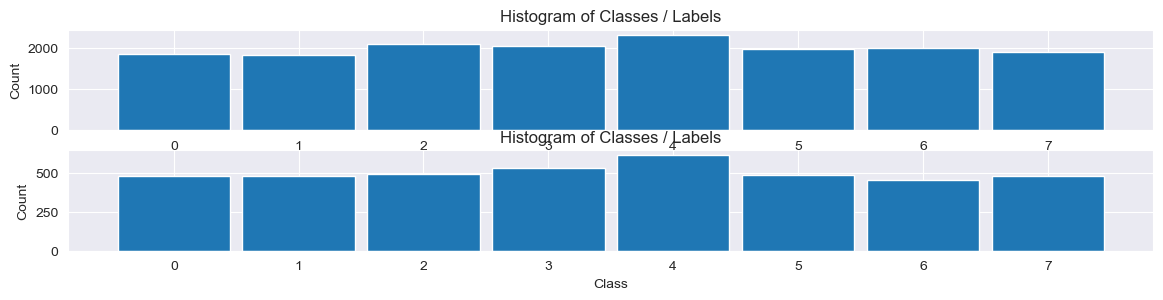

Prediction Train Accuracy: 99.97 %
Prediction Test Accuracy: 77.94 %


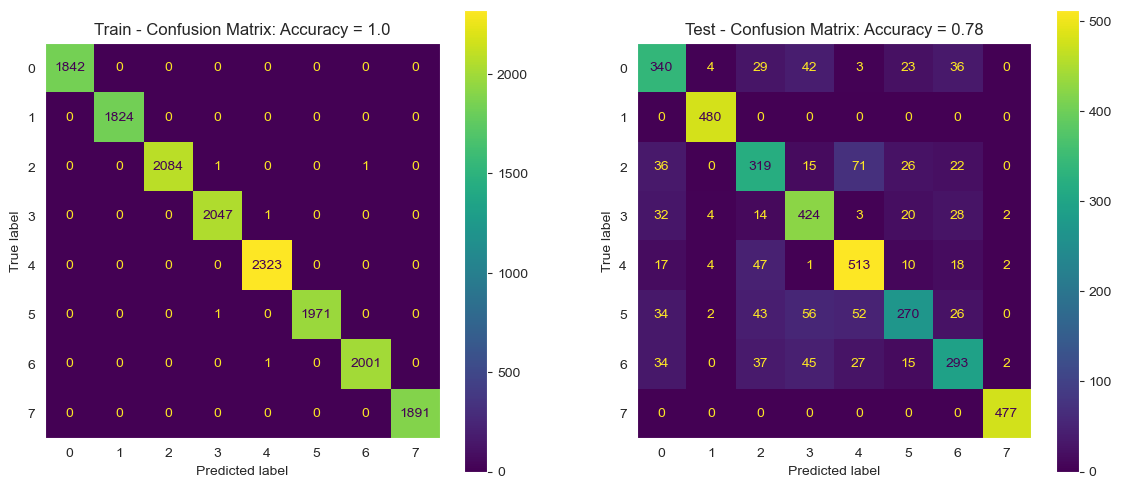

In [18]:
# Test features with a simple model
TestFeaturesInSimpleModel(speech_data_array,speech_label_array)

## DEBUG

In [ ]:
def SortDataDescent(data,column_ind):
    return data[data[:,column_ind].argsort()[::-1]]

def DataPreprocessing(n_mfcc):
    dump_filename_data = 'speech_data_features.csv'
    dump_filename_label = 'speech_label.csv'
    if False: # os.path.isfile(dump_filename_data) and os.path.isfile(dump_filename_label):
        speech_data_array = lib.LoadCsv(dump_filename_data)
        speech_label_array = lib.LoadCsv(dump_filename_label)
    else:
        speech_data_features = []  # stores the features
        speech_labels = []  # stores the labels
        for data_path in tqdm(data_paths,desc="Collecting Datasets"):
            root_dir = data_path[2]
            cpt = sum([len(d) for r, d, files in os.walk(root_dir)])+1
            for subdirs, dirs, files in tqdm(os.walk(root_dir), total=cpt, desc=f'Processing {data_path[0]} audio files', unit="file"):
                for file in files:
                    if not '.wav' in file:
                        continue
                    audio_file_path = os.path.join(subdirs, file)
                    features = ExtractFeatures(audio_file_path,n_mfcc)
                    label = ExtractLabel(file,data_path[0])
                    speech_data_features.append(features)
                    speech_labels.append(label)
        speech_data_array = np.asarray(speech_data_features)
        speech_label_array = np.array(speech_labels)
        lib.SaveCsv(dump_filename_data,speech_data_array)
        lib.SaveCsv(dump_filename_label,speech_label_array)
    dataL1 = speech_data_array[(speech_label_array==1)]
    L1 = speech_label_array[(speech_label_array==1)]
    dataL7 = speech_data_array[(speech_label_array==7)]
    L7 = speech_label_array[(speech_label_array==7)]
    speech_data_array = np.concatenate((speech_data_array,dataL1,dataL1,dataL1,dataL1,dataL1,dataL7),axis=0)
    speech_label_array = np.concatenate((speech_label_array,L1,L1,L1,L1,L1,L7),axis=0)
    score = TestFeaturesInSimpleModel(speech_data_array,speech_label_array)
    return score

def GridSearch():
    l_n_mfccs = np.arange(5,128)
    lScore = np.zeros([len(l_n_mfccs),2])
    for ii in tqdm(range(len(l_n_mfccs)), desc='Grid Searching model'):
        lScore[ii,0] = DataPreprocessing(l_n_mfccs[ii])
        lScore[ii,1] = l_n_mfccs[ii]
    best_results = SortDataDescent(lScore,0)
    best_score = best_results[0,0]
    best_n_mfcc = best_results[0,1]
    print(f'GridSearched: Best result for n_mfcc = {best_n_mfcc} with test score = {best_score}.')

GridSearch()

In [ ]:
# Test Logistic Regression
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

root_dir = "data/ravdess/audio_speech_actors_01-24"

speech_data_features = np.zeros([1440,254])  # stores the features
speech_labels = []  # stores the labels
ii=0

for subdirs, dirs, files in tqdm(os.walk(root_dir), desc="Processing audio files", unit="file"):
    for file in files:
        speech_labels.append(int(file[7:8]) - 1)
        audio_file_path = os.path.join(subdirs, file)
        y, sr = librosa.load(audio_file_path)
        rms = librosa.feature.rms(y=y)
        speech_data_features[ii,:rms.shape[1]] = rms[0,:]
        ii += 1

speech_label_array = np.array(speech_labels)
display(speech_data_features.shape)
display(speech_label_array.shape)

Processing audio files: 0file [00:00, ?file/s]

(1440, 254)

(1440,)

In [ ]:
oLR = LogisticRegression(random_state=0)
oLR.fit(speech_data_features, speech_label_array)
oLR.coef_.shape

(8, 254)

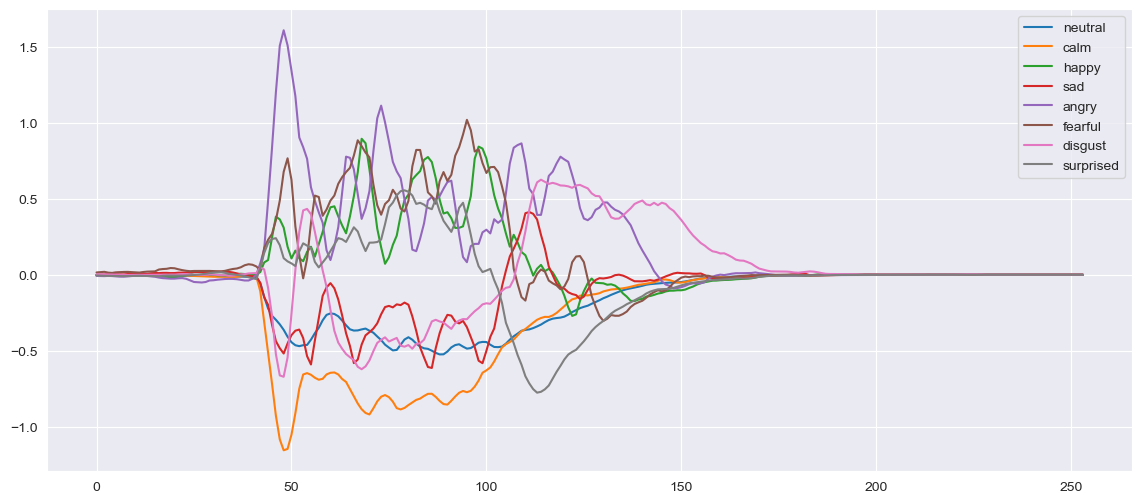

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(oLR.coef_[0,:],label='neutral')
plt.plot(oLR.coef_[1,:],label='calm')
plt.plot(oLR.coef_[2,:],label='happy')
plt.plot(oLR.coef_[3,:],label='sad')
plt.plot(oLR.coef_[4,:],label='angry')
plt.plot(oLR.coef_[5,:],label='fearful')
plt.plot(oLR.coef_[6,:],label='disgust')
plt.plot(oLR.coef_[7,:],label='surprised')
plt.legend()
plt.show()

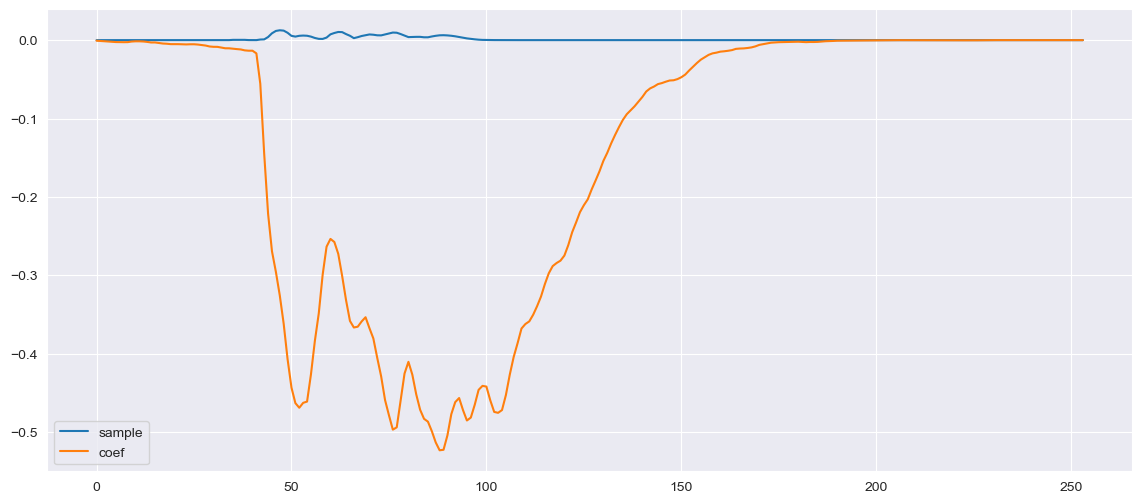

In [ ]:
sample_num = 0
plt.figure(figsize=(14, 6))
plt.plot(speech_data_features[sample_num,:],label='sample')
plt.plot(oLR.coef_[sample_num,:],label='coef')
plt.legend()
plt.show()

In [ ]:
np.correlate(oLR.coef_[0,:],speech_data_features[0,:])

array([-0.12773967])

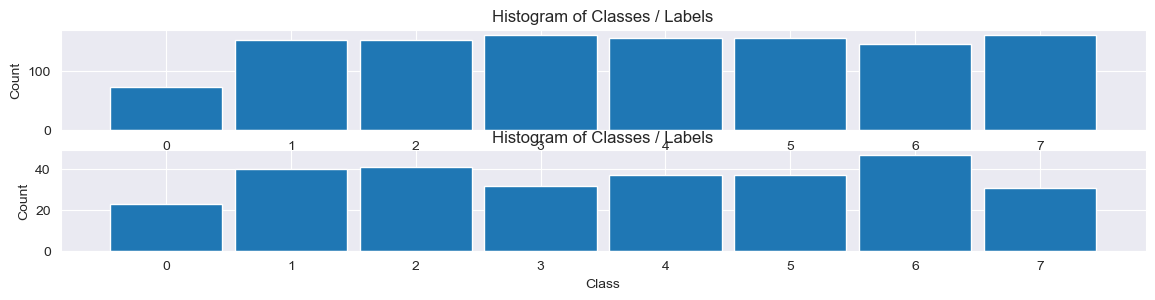

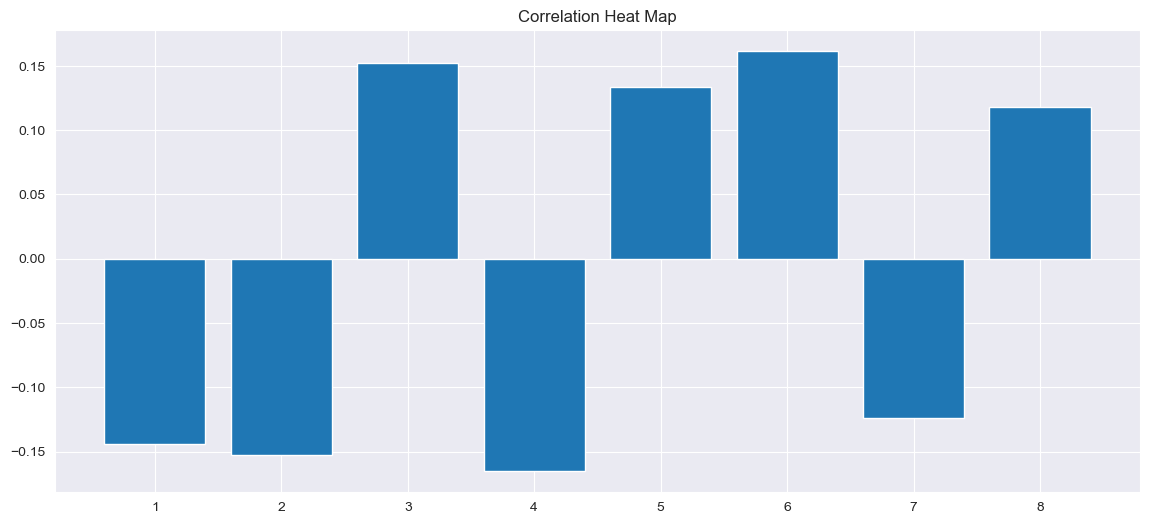

Prediction Train Accuracy: 95.92 %
Prediction Test Accuracy: 34.38 %


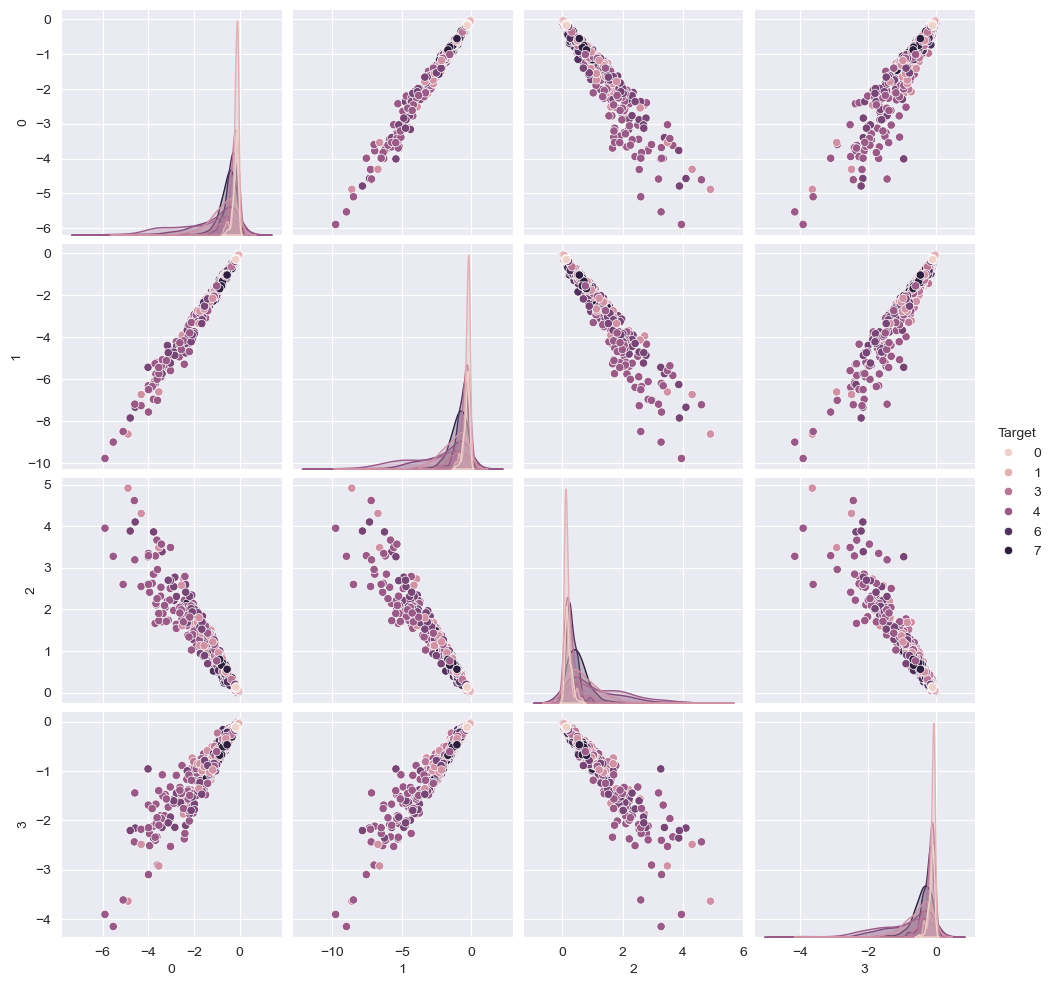

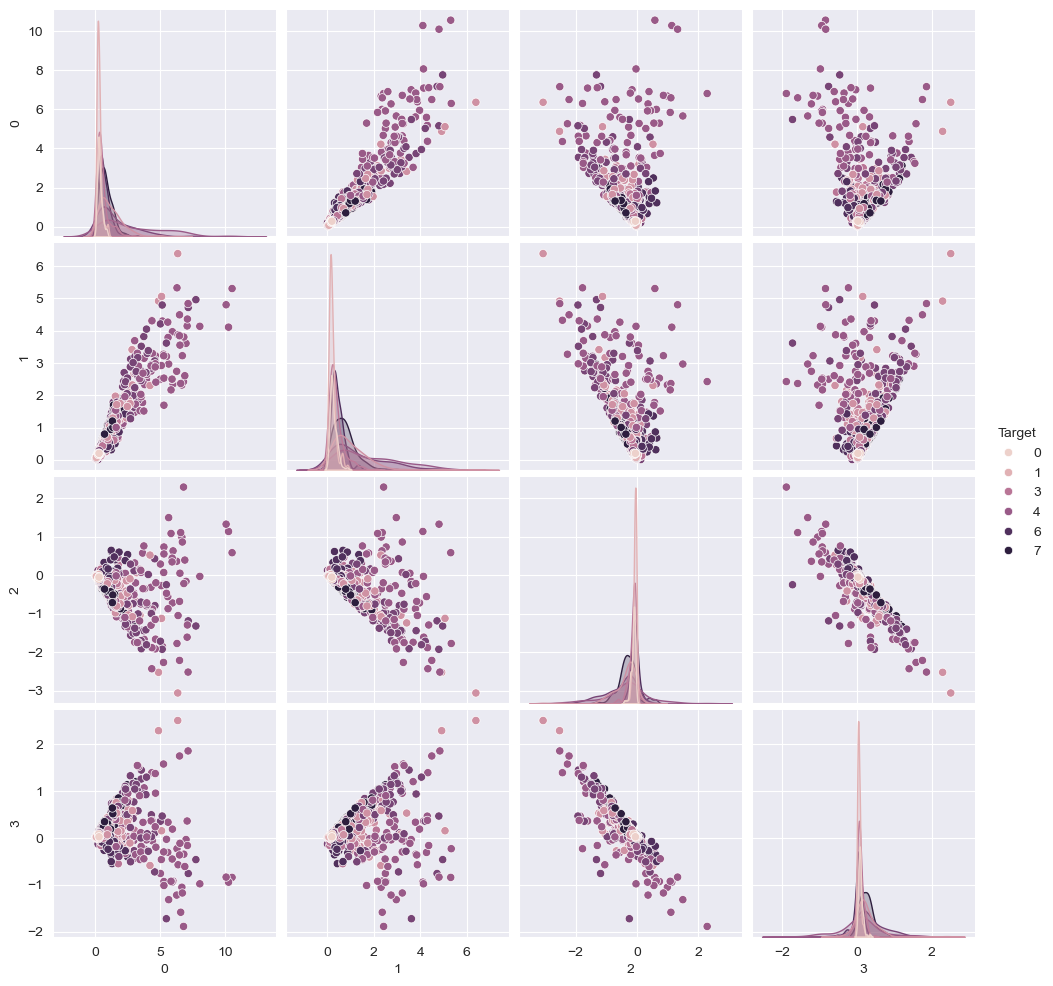

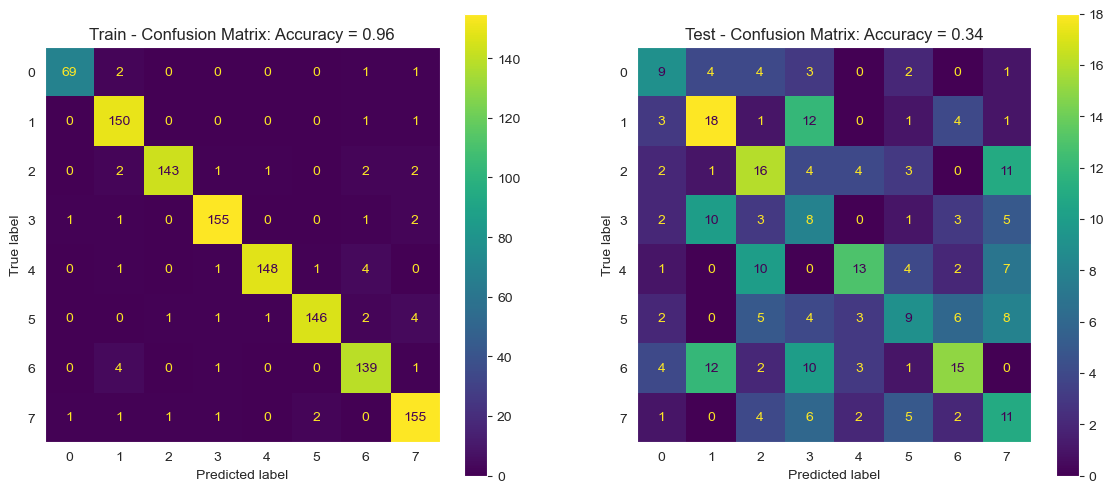

In [ ]:
TestFeaturesInSimpleModel(speech_data_features @ oLR.coef_.T,speech_label_array)